# Noise2Void 

In [ ]:
!cp -r /content/drive/MyDrive/SYDE522/n2v-master /content

In [ ]:
%cd /content/drive/MyDrive/n2v-master

/content/drive/MyDrive/n2v-master


In [ ]:
!pip install csbdeep
!pip install ruamel.yaml

In [ ]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Training Data Preparation

In [ ]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/BSD68_reproducibility.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [ ]:
X = np.load('/content/drive/MyDrive/n2v-master/data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('/content/drive/MyDrive/n2v-master/data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following lines.
# X = np.round(np.clip(X, 0, 255.))
# X_val = np.round(np.clip(X_val, 0, 255.))

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180, 1)
(4, 180, 180, 1)


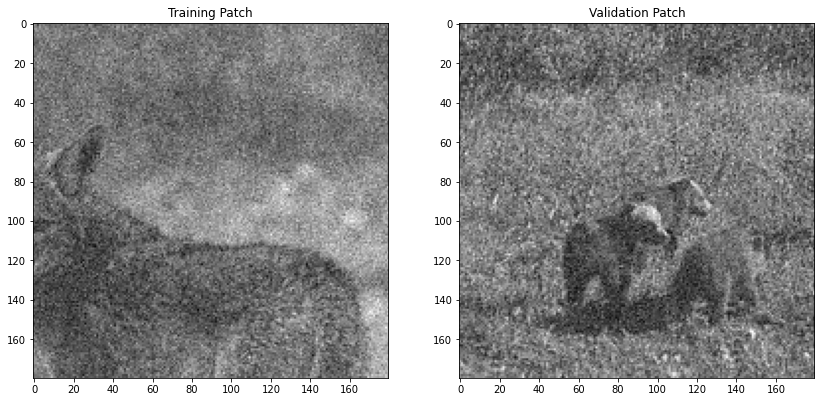

In [ ]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

# Configure

In [ ]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=400, train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=2,
                   single_net_per_channel=False)

In [ ]:
# a name used to identify the model
model_name = 'BSD68_reproducability_5x5'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

/content/drive/MyDrive/n2v-master/n2v/models/n2v_standard.py:416: UserWarning: output path for model already exists, files may be overwritten: /content/drive/MyDrive/n2v-master/models/BSD68_reproducability_5x5
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

/content/n2v-master/n2v/models/n2v_standard.py:194: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 405.77it/s]

Epoch 1/200


400/400 [==============================] - 102s 225ms/step - loss: 0.2245 - val_loss: 0.2678 - lr: 4.0000e-04
Epoch 2/200
400/400 [==============================] - 89s 221ms/step - loss: 0.2075 - val_loss: 0.2213 - lr: 4.0000e-04
Epoch 3/200
400/400 [==============================] - 88s 221ms/step - loss: 0.2054 - val_loss: 0.2179 - lr: 4.0000e-04
Epoch 4/200
400/400 [==============================] - 88s 221ms/step - loss: 0.2029 - val_loss: 0.2431 - lr: 4.0000e-04
Epoch 5/200
400/400 [==============================] - 88s 221ms/step - loss: 0.2011 - val_loss: 0.2051 - lr: 4.0000e-04
Epoch 6/200
400/400 [==============================] - 88s 221ms/step - loss: 0.2013 - val_loss: 0.2196 - lr: 4.0000e-04
Epoch 7/200
400/400 [==============================] - 88s 221ms/step - loss: 0.2007 - val_loss: 0.2156 - lr: 4.0000e-04
Epoch 8/200
400/400 [==============================] - 88s 221ms/step - loss: 0.2011 - val_loss: 0.2114 - lr: 4.0000e-04
Epoch 9/200
400/400 [======================

# Compute PSNR to GT

In [ ]:
groundtruth_data = np.load('/content/drive/MyDrive/n2v-master/data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [ ]:
test_data = np.load('/content/drive/MyDrive/n2v-master/data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)

In [ ]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [ ]:
# The weights of the converged network. 
model.load_weights('/content/drive/MyDrive/n2v-master/models/BSD68_reproducability_5x5/weights_last.h5')

In [ ]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=False)
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

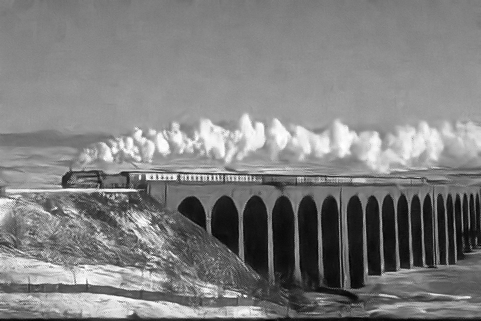

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(pred[39])

In [ ]:
print("PSNR:", np.round(np.mean(psnrs), 2))

PSNR: 27.67
